In [6]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import joblib

In [7]:
# Load the datasets
train_df = pd.read_csv('train.csv')  # Replace with the path to your train.csv
test_df = pd.read_csv('test.csv')    # Replace with the path to your test.csv

In [8]:
# Display basic information about the dataset
print(train_df.info())
print(train_df.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [9]:
# Data Cleaning: Handle missing values
# For simplicity, we'll drop columns with too many missing values and fill the rest
missing_value_threshold = 0.5  # Drop columns with more than 50% missing values
train_df = train_df.loc[:, train_df.isnull().mean() < missing_value_threshold]
test_df = test_df.loc[:, test_df.isnull().mean() < missing_value_threshold]


In [10]:
# Fill missing values for numerical columns with median
for col in train_df.select_dtypes(include=[np.number]).columns:
    train_df[col].fillna(train_df[col].median(), inplace=True)

for col in test_df.select_dtypes(include=[np.number]).columns:
    test_df[col].fillna(test_df[col].median(), inplace=True)


C:\Users\harth\AppData\Local\Temp\ipykernel_13556\2711324808.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train_df[col].fillna(train_df[col].median(), inplace=True)
C:\Users\harth\AppData\Local\Temp\ipykernel_13556\2711324808.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy

In [11]:
# Fill missing values for categorical columns with mode
for col in train_df.select_dtypes(include=[object]).columns:
    train_df[col].fillna(train_df[col].mode()[0], inplace=True)

for col in test_df.select_dtypes(include=[object]).columns:
    test_df[col].fillna(test_df[col].mode()[0], inplace=True)


C:\Users\harth\AppData\Local\Temp\ipykernel_13556\3540236095.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train_df[col].fillna(train_df[col].mode()[0], inplace=True)
C:\Users\harth\AppData\Local\Temp\ipykernel_13556\3540236095.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a cop

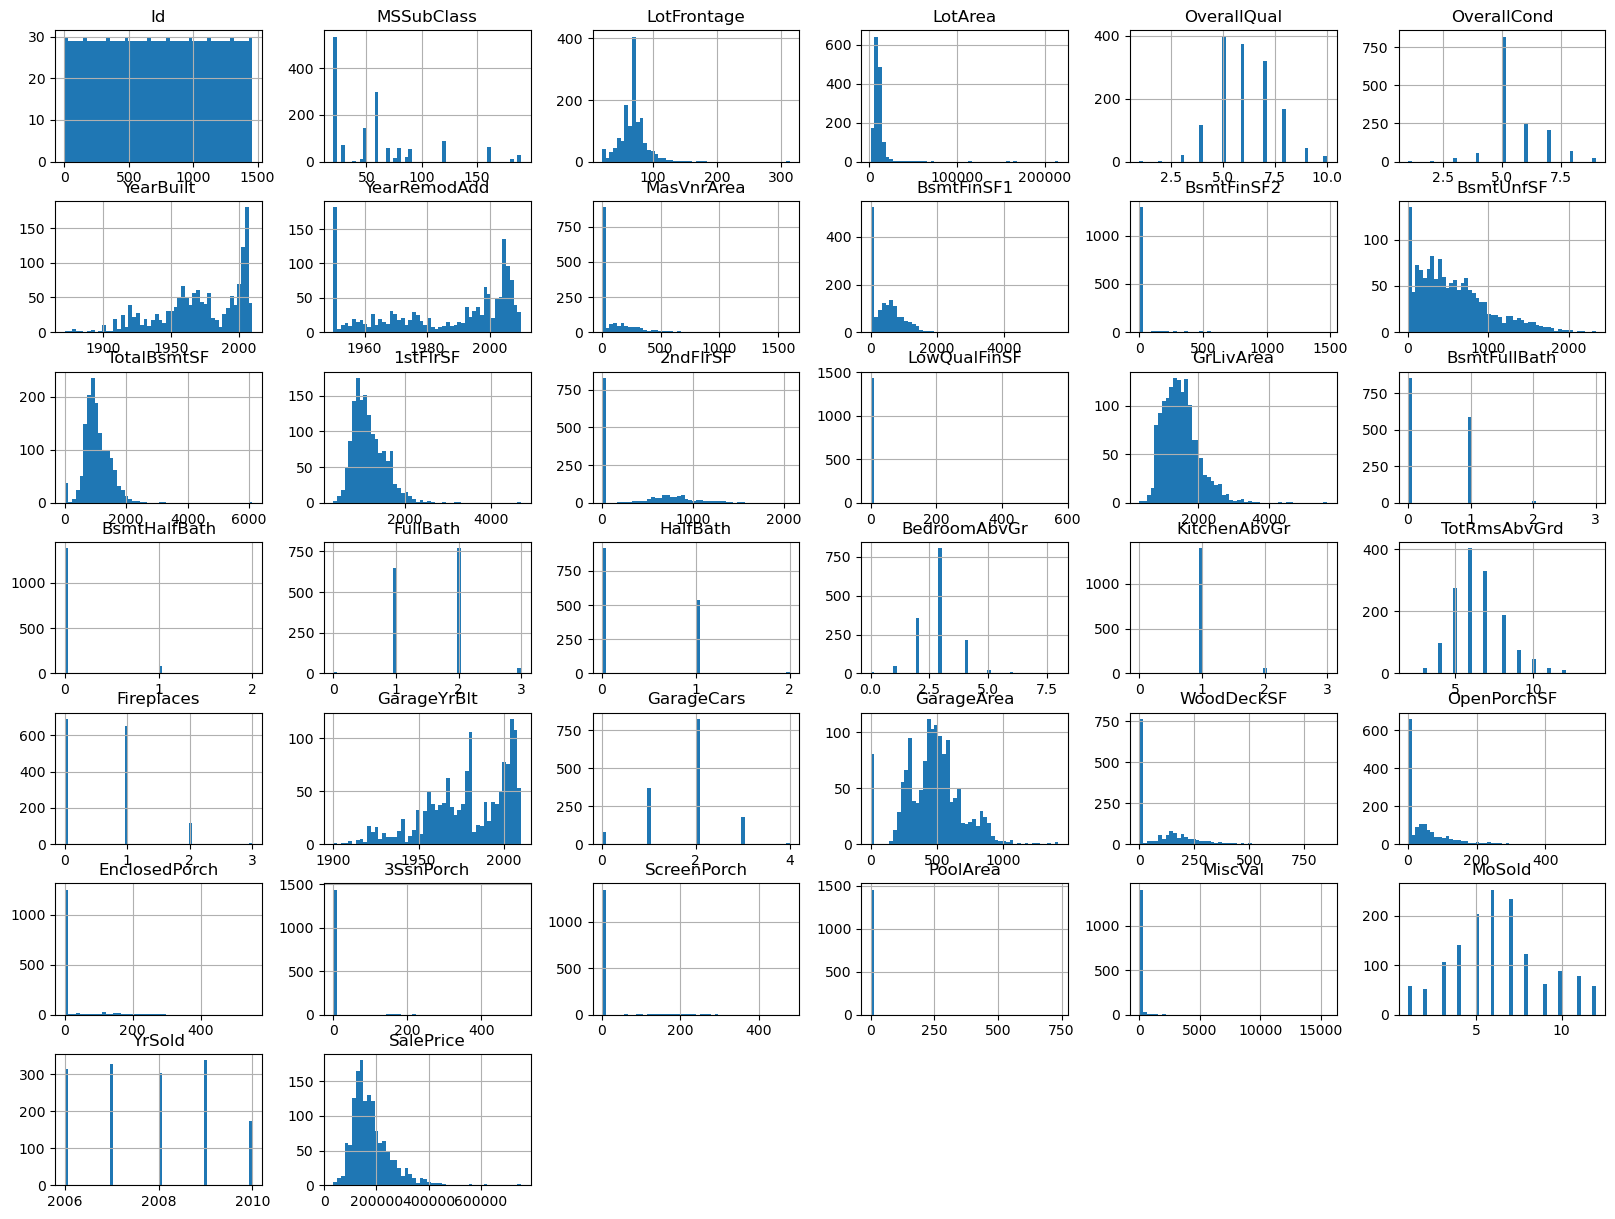

In [12]:
# Exploratory Data Analysis (EDA)
# Plot distributions of the numerical features
train_df.hist(bins=50, figsize=(20, 15))
plt.show()


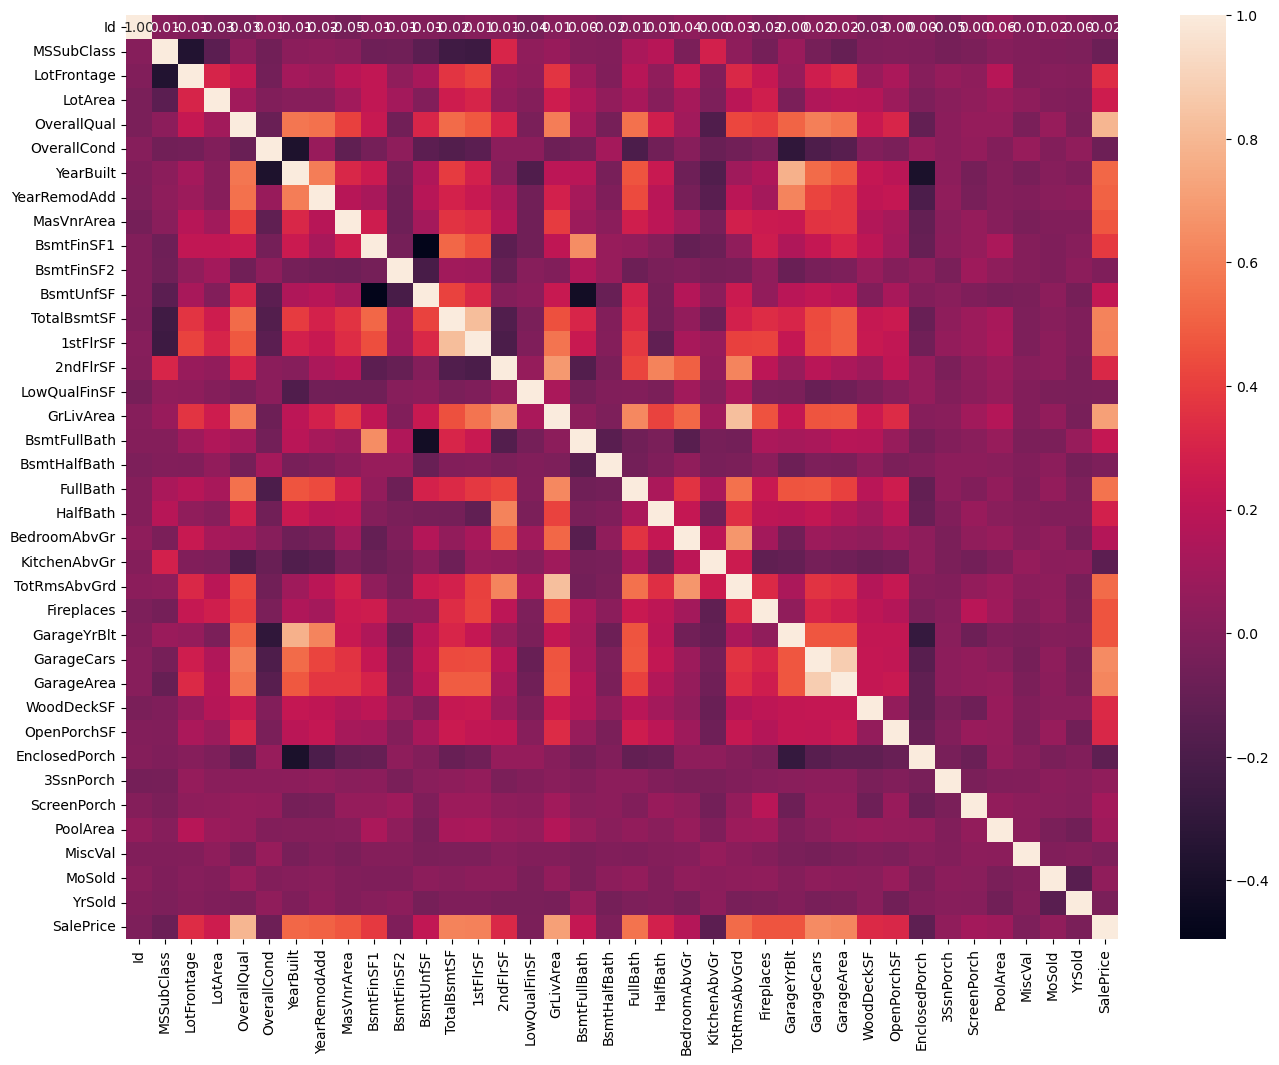

In [13]:
# Plot correlation matrix for numerical features only
plt.figure(figsize=(16, 12))
sns.heatmap(train_df.select_dtypes(include=[np.number]).corr(), annot=True, fmt=".2f")
plt.show()


In [14]:
# Feature Engineering
# Example: Create a new feature 'TotalSF' (total square footage)
train_df['TotalSF'] = train_df['TotalBsmtSF'] + train_df['1stFlrSF'] + train_df['2ndFlrSF']
test_df['TotalSF'] = test_df['TotalBsmtSF'] + test_df['1stFlrSF'] + test_df['2ndFlrSF']

# Split the train dataset into training and validation sets
X = train_df.drop(['SalePrice'], axis=1)
y = train_df['SalePrice']
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)


In [15]:
# Preprocessing and model pipeline
numeric_features = X.select_dtypes(include=[np.number]).columns
categorical_features = X.select_dtypes(include=[object]).columns

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])


In [16]:
# Define the models to be evaluated
models = {
    'Linear Regression': LinearRegression(),
    'Random Forest': RandomForestRegressor(random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(random_state=42)
}


In [17]:
# Function to evaluate models
def evaluate_model(model, X_train, y_train, X_val, y_val):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)
    mae = mean_absolute_error(y_val, y_pred)
    mse = mean_squared_error(y_val, y_pred)
    r2 = r2_score(y_val, y_pred)
    return mae, mse, r2


In [18]:
# Train and evaluate models
results = {}
for name, model in models.items():
    clf = Pipeline(steps=[('preprocessor', preprocessor),
                          ('model', model)])
    mae, mse, r2 = evaluate_model(clf, X_train, y_train, X_val, y_val)
    results[name] = {'MAE': mae, 'MSE': mse, 'R2': r2}
    print(f'{name} - MAE: {mae}, MSE: {mse}, R2: {r2}')

# Select the best model (for example, Gradient Boosting)
best_model = Pipeline(steps=[('preprocessor', preprocessor),
                             ('model', GradientBoostingRegressor(random_state=42))])


Linear Regression - MAE: 18440.04601693486, MSE: 891028494.1283916, R2: 0.8838343415833483
Random Forest - MAE: 17908.225650684933, MSE: 900704212.4195249, R2: 0.8825728935002058
Gradient Boosting - MAE: 16532.608380448848, MSE: 763910860.787647, R2: 0.9004069918080069


In [19]:
# Hyperparameter tuning for the best model using GridSearchCV
param_grid = {
    'model__n_estimators': [100, 200],
    'model__learning_rate': [0.05, 0.1],
    'model__max_depth': [3, 4, 5]
}

grid_search = GridSearchCV(best_model, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search.fit(X_train, y_train)

print(f'Best parameters: {grid_search.best_params_}')
print(f'Best score: {grid_search.best_score_}')


Best parameters: {'model__learning_rate': 0.05, 'model__max_depth': 3, 'model__n_estimators': 200}
Best score: -788317893.7252007


In [20]:
# Train the final model with the best parameters
final_model = grid_search.best_estimator_
final_model.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  Index(['Id', 'MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual',
       'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrS...
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional',
       'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond',
       'PavedDrive', 'SaleType', 'SaleCondition'],
      dtype='object'))])),
                ('model',
                 GradientBoostingRegressor(learning_rate=0.05, n_estimators=200,
                                           random_state=42))])

In [21]:
# Evaluate the final model on the validation set
y_pred = final_model.predict(X_val)
print(f'Final Model - MAE: {mean_absolute_error(y_val, y_pred)}, MSE: {mean_squared_error(y_val, y_pred)}, R2: {r2_score(y_val, y_pred)}')

Final Model - MAE: 16177.364131557142, MSE: 752540118.7971635, R2: 0.901889424456025


In [24]:
from sklearn.impute import SimpleImputer

# Ensuring consistent columns between train and test data
missing_cols = set(train_df.columns) - set(test_df.columns)
for col in missing_cols:
    test_df[col] = np.nan

# Align columns order with training data
test_df = test_df[train_df.columns]

# Feature Engineering: Example for 'TotalSF'
train_df['TotalSF'] = train_df['TotalBsmtSF'] + train_df['1stFlrSF'] + train_df['2ndFlrSF']
test_df['TotalSF'] = test_df['TotalBsmtSF'] + test_df['1stFlrSF'] + test_df['2ndFlrSF']

# Define preprocessing and modeling pipeline
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import SimpleImputer
import joblib

# Preprocessing for numerical data
numerical_features = train_df.select_dtypes(include=[np.number]).columns.tolist()
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

# Preprocessing for categorical data
categorical_features = train_df.select_dtypes(include=['object']).columns.tolist()
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

# Combine numerical and categorical transformers
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)])

# Define the model
model = RandomForestRegressor(n_estimators=100, random_state=42)

# Create and fit the pipeline
pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('model', model)])

pipeline.fit(train_df, y)

# Save the model
joblib.dump(pipeline, 'house_price_predictor.pkl')

# Make predictions on the test set
test_predictions = pipeline.predict(test_df)

# Create a submission file
submission = pd.DataFrame({'Id': test_df['Id'], 'SalePrice': test_predictions})
submission.to_csv('submission.csv', index=False)
